In [ ]:
#Tall Matrix 


using CUDA
using Plots
using BenchmarkTools
using LinearAlgebra

# SVD

function TestGPU(N, C)
    
    Time = zeros(Float64, length(N))

    BenchmarkTools.DEFAULT_PARAMETERS.samples = C

    for (i,a) in enumerate(N)
        @show (i,a)
        X = CUDA.randn(Float64, 1, a)         
        data = @benchmark CUDA.@sync svd($X)
        Time[i] = mean(data.times) / 1e6  # Convert to milliseconds

    end

    return Time

end

function TestCPU(N, C)
    
    Time = zeros(Float64, length(N))

    BenchmarkTools.DEFAULT_PARAMETERS.samples = C

    for (i,a) in enumerate(N)
        @show (i,a)
        X = randn(Float64, 1, a)        
        data = @benchmark svd($X)
        Time[i] = mean(data.times) / 1e6  # Convert to milliseconds
    end

    return Time

end


N = 2 .^ (8:12)
C = 5
timesGPU = TestGPU(N, C)
timesCPU = TestCPU(N, C)

#---------------------------------------------------------------------------------------#
x_pos = maximum(N) * 0.95  # Adjust to position the text within the plot area
y_pos = minimum(timesGPU) * 1.05  # Adjust based on the minimum time value


cpu_info = Sys.cpu_info()[1].model # display device name
gpu_info = CUDA.name(CUDA.device()) # display device name
#---------------------------------------------------------------------------------------#

p1 = plot(N, timesGPU, title="Time vs Matrix Size in Singular Value Decomposition", xlabel="Matrix Size (N)", xaxis=:log, ylabel="Time (ms)", yaxis=:log, label="GPU", marker=:circle, legend=:topright, grid=:on, minorgrid=true)
plot!(p1, N, timesCPU, label="CPU", marker=:circle)
annotate!(p1, [(x_pos, y_pos, text("Iterations: $C\nCPU: $cpu_info\nGPU: $gpu_info", 8, :right, :bottom))])

In [ ]:
#Long Matrix 


using CUDA
using Plots
using BenchmarkTools
using LinearAlgebra

# SVD

function TestGPU(N, C)
    
    Time = zeros(length(N))

    BenchmarkTools.DEFAULT_PARAMETERS.samples = C

    for (i,a) in enumerate(N)
        @show (i,a)
        X = CUDA.randn(a, a)         
        data = @benchmark CUDA.@sync svd($X)
        Time[i] = mean(data.times) / 1e6  # Convert to milliseconds

    end

    return Time

end

function TestCPU(N, C)
    
    Time = zeros(length(N))

    BenchmarkTools.DEFAULT_PARAMETERS.samples = C

    for (i,a) in enumerate(N)
        @show (i,a)
        X = randn(a, a)        
        data = @benchmark svd($X)
        Time[i] = mean(data.times) / 1e6  # Convert to milliseconds
    end

    return Time

end


N = 2 .^ (8:12)
C = 5
timesGPU = TestGPU(N, C)
timesCPU = TestCPU(N, C)

#---------------------------------------------------------------------------------------#
x_pos = maximum(N) * 0.95  # Adjust to position the text within the plot area
y_pos = minimum(timesGPU) * 1.05  # Adjust based on the minimum time value


cpu_info = Sys.cpu_info()[1].model # display device name
gpu_info = CUDA.name(CUDA.device()) # display device name
#---------------------------------------------------------------------------------------#

p1 = plot(N, timesGPU, title="Time vs Matrix Size in Singular Value Decomposition", xlabel="Matrix Size (N)", xaxis=:log, ylabel="Time (ms)", yaxis=:log, label="GPU", marker=:circle, legend=:topright, grid=:on, minorgrid=true)
plot!(p1, N, timesCPU, label="CPU", marker=:circle)
annotate!(p1, [(x_pos, y_pos, text("Iterations: $C\nCPU: $cpu_info\nGPU: $gpu_info", 8, :right, :bottom))])

In [8]:
using CUDA
using LinearAlgebra

A_cpu = randn(Float64, 8192, 64)

SVD_Result_cpu = svd(A_cpu)

U_cpu = SVD_Result_cpu.U
S_cpu = SVD_Result_cpu.S
Vt_cpu = SVD_Result_cpu.Vt

relative_S_cpu = S_cpu / maximum(S_cpu)

# Define a threshold
gamma = 0.5

k = sum(relative_S_cpu .> gamma)

Uk_cpu = U_cpu[:, 1:k]
Sk_cpu = Diagonal(S_cpu[1:k]) 
Vtk_cpu = Vt_cpu[1:k, :]

A_truncated_cpu = Uk_cpu * Sk_cpu * Vtk_cpu

A_truncated = Array(A_truncated_cpu)

println("Size of the truncated matrix A_truncated is $(size(A_truncated))")
println("The number of significant singular values k is $k") 
relative_S_cpu

Size of the truncated matrix A_truncated is (8192, 64)
The number of significant singular values k is 64


64-element Vector{Float64}:
 1.0
 0.9927218873738075
 0.9909875655459476
 0.9858129512660291
 0.9826201338921503
 0.9801762012293376
 0.9765107942428151
 0.9746198726085973
 0.9732597284865575
 0.968650700318643
 0.9660286900542929
 0.9622581530953596
 0.9591391080445056
 ⋮
 0.8752114898855764
 0.873196607323351
 0.8715595359502963
 0.8704281984433772
 0.8695510723333073
 0.8661395008138624
 0.8626943370663901
 0.8609655225698915
 0.8599405512869055
 0.8552362619280184
 0.8495020052701366
 0.844424546072342

In [10]:
using CUDA
using LinearAlgebra
using BenchmarkTools

A_gpu = CUDA.randn(Float64, 8192, 64)

SVD_Result_gpu = svd(A_gpu)
U_gpu = SVD_Result_gpu.U
S_gpu = SVD_Result_gpu.S
Vt_gpu = SVD_Result_gpu.Vt

# Function to perform truncation based on a threshold and return the number of significant singular values
function count_significant_singular_values(S, gamma)
    relative_S = S / maximum(S)
    k = sum(relative_S .> gamma)
    return k
end

initial_k = length(S_gpu)
gamma = 1

time_elapsed = @benchmark begin
    k = initial_k
    while k == initial_k  # Continue until k decreases
        @show ($gamma)
        k = count_significant_singular_values($S_gpu, $gamma)
        $gamma /= 2  # Logarithmic reduction of the threshold
    end
end

# Final state and print results
println("Final gamma: $gamma")
println("The number of significant singular values k is $k")
println("Time taken (ms): ", mean(time_elapsed.times) / 1e6)  # Convert to milliseconds

var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#946" = 1
var"##gamma#9

In [2]:
using CUDA
using LinearAlgebra

A_gpu = CUDA.randn(Float64, 8192, 64)

SVD_Result_gpu = svd(A_gpu)

U_gpu = SVD_Result_gpu.U
S_gpu = SVD_Result_gpu.S
Vt_gpu = SVD_Result_gpu.Vt

relative_S_gpu = S_gpu / maximum(S_gpu)

# Define a threshold
gamma = 0.5

k = sum(relative_S_gpu .> gamma)

Uk_gpu = U_gpu[:, 1:k]
Sk_gpu = Diagonal(S_gpu[1:k]) 
Vtk_gpu = Vt_gpu[1:k, :]

A_truncated_gpu = Uk_gpu * Sk_gpu * Vtk_gpu

A_truncated = Array(A_truncated_gpu)

println("Size of the truncated matrix A_truncated is $(size(A_truncated))")
println("The number of significant singular values k is $k")

Size of the truncated matrix A_truncated is (8192, 64)
The number of significant singular values k is 64


(i, m, n) = (1, 256, 64)
(i, m, n) = (2, 512, 128)
(i, m, n) = (3, 1024, 256)
(i, m, n) = (4, 2048, 512)
(i, m, n) = (5, 4096, 1024)
(i, m, n) = (1, 256, 64)
(i, m, n) = (2, 512, 128)
(i, m, n) = (3, 1024, 256)
(i, m, n) = (4, 2048, 512)
(i, m, n) = (5, 4096, 1024)


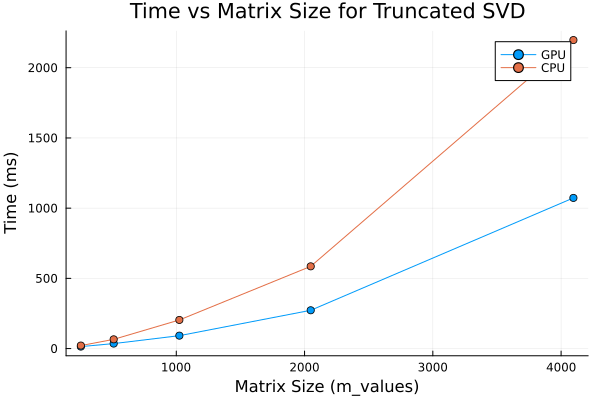

In [5]:
using CUDA
using Plots
using BenchmarkTools
using LinearAlgebra

# Function to benchmark truncated SVD on GPU
function TestGPU_SVDTruncation(m_values, n_values, C, gamma)
    Time = zeros(Float64, length(m_values))
    K_values = zeros(Int, length(m_values))

    BenchmarkTools.DEFAULT_PARAMETERS.samples = C

    for (i, (m, n)) in enumerate(zip(m_values, n_values))
        @show (i, m, n)
        A_gpu = CUDA.randn(Float64, m, n)
        data = @benchmark begin SVD_Result_gpu = svd($A_gpu)
            S_gpu = SVD_Result_gpu.S
            relative_S_gpu = $S_gpu / maximum($S_gpu)
            k = sum($relative_S_gpu .> $gamma)
            Uk_gpu = $SVD_Result_gpu.U[:, 1:k]
            Sk_gpu = Diagonal($S_gpu[1:k])
            Vtk_gpu = $SVD_Result_gpu.Vt[1:k, :]
            A_truncated_gpu = $Uk_gpu * $Sk_gpu * $Vtk_gpu
        end
        Time[i] = mean(data.times) / 1e6  # Convert to milliseconds
        K_values[i] = k
    end

    return Time, K_values
end

# Function to benchmark truncated SVD on CPU
function TestCPU_SVDTruncation(m_values, n_values, C, gamma)
    Time = zeros(Float64, length(m_values))
    K_values = zeros(Int, length(m_values))

    BenchmarkTools.DEFAULT_PARAMETERS.samples = C

    for (i, (m, n)) in enumerate(zip(m_values, n_values))
        @show (i, m, n)
        A_cpu = randn(Float64, m, n)
        data = @benchmark begin
            SVD_Result_cpu = svd($A_cpu)
            S_cpu = SVD_Result_cpu.S
            relative_S_cpu = $S_cpu / maximum($S_cpu)
            k = sum($relative_S_cpu .> $gamma)
            Uk_cpu = $SVD_Result_cpu.U[:, 1:k]
            Sk_cpu = Diagonal($S_cpu[1:k])
            Vtk_cpu = $SVD_Result_cpu.Vt[1:k, :]
            A_truncated_cpu = $Uk_cpu * $Sk_cpu * $Vtk_cpu
        end
        Time[i] = mean(data.times) / 1e6  # Convert to milliseconds
        K_values[i] = k
    end

    return Time, K_values
end

# Example matrix dimensions
m_values = 2 .^ (8:12)
n_values = [64, 128, 256, 512, 1024]
C = 20
gamma = 0.5
timesGPU, kGPU = TestGPU_SVDTruncation(m_values, n_values, C, gamma)
timesCPU, kCPU = TestCPU_SVDTruncation(m_values, n_values, C, gamma)

# Plotting the results
p1 = plot(m_values, timesGPU, title="Time vs Matrix Size for Truncated SVD", xlabel="Matrix Size (m_values)", ylabel="Time (ms)", label="GPU", marker=:circle, legend=:topright)
plot!(p1, m_values, timesCPU, label="CPU", marker=:circle)

(i, m, n) = (1, 256, 64)
(i, m, n) = (2, 512, 128)
(i, m, n) = (3, 1024, 256)
(i, m, n) = (4, 2048, 512)
(i, m, n) = (5, 4096, 1024)
(i, m, n) = (1, 256, 64)
(i, m, n) = (2, 512, 128)
(i, m, n) = (3, 1024, 256)
(i, m, n) = (4, 2048, 512)
(i, m, n) = (5, 4096, 1024)


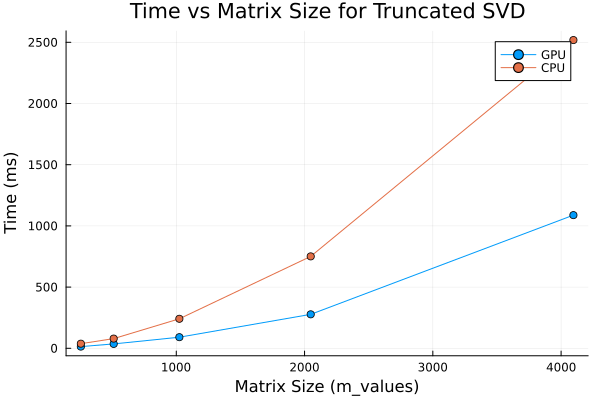

In [9]:
using CUDA
using Plots
using BenchmarkTools
using LinearAlgebra

# Function to benchmark truncated SVD on GPU
function TestGPUSVDTruncation(m_values, n_values, C, gamma)
    Time = zeros(Float64, length(m_values))
    K_values = zeros(Int, length(m_values))

    BenchmarkTools.DEFAULT_PARAMETERS.samples = C

    for (i, (m, n)) in enumerate(zip(m_values, n_values))
        @show (i, m, n)
        A_gpu = CUDA.randn(Float64, m, n)
        data = @benchmark begin
            SVD_Result_gpu = svd($A_gpu)
            relative_S_gpu = $SVD_Result_gpu.S / maximum($SVD_Result_gpu.S)
            k = sum($relative_S_gpu .> $gamma)
            Uk_gpu = $SVD_Result_gpu.U[:, 1:k]
            Sk_gpu = Diagonal($SVD_Result_gpu.S[1:k])
            Vtk_gpu = $SVD_Result_gpu.Vt[1:k, :]
            A_truncated_gpu = $Uk_gpu * $Sk_gpu * $Vtk_gpu
        end
        Time[i] = mean(data.times) / 1e6  # Convert to milliseconds
        K_values[i] = k
    end

    return Time, K_values
end

# Function to benchmark truncated SVD on CPU
function TestCPUSVDTruncation(m_values, n_values, C, gamma)
    Time = zeros(Float64, length(m_values))
    K_values = zeros(Int, length(m_values))

    BenchmarkTools.DEFAULT_PARAMETERS.samples = C

    for (i, (m, n)) in enumerate(zip(m_values, n_values))
        @show (i, m, n)
        A_cpu = randn(Float64, m, n)
        data = @benchmark begin
            SVD_Result_cpu = svd($A_cpu)
            relative_S_cpu = $SVD_Result_cpu.S / maximum($SVD_Result_cpu.S)
            k = sum($relative_S_cpu .> $gamma)
            Uk_cpu = $SVD_Result_cpu.U[:, 1:k]
            Sk_cpu = Diagonal($SVD_Result_cpu.S[1:k])
            Vtk_cpu = $SVD_Result_cpu.Vt[1:k, :]
            A_truncated_cpu = $Uk_cpu * $Sk_cpu * $Vtk_cpu
        end
        Time[i] = mean(data.times) / 1e6  # Convert to milliseconds
        K_values[i] = k
    end

    return Time, K_values
end

# Example matrix dimensions
m_values = 2 .^ (8:12)
n_values = [64, 128, 256, 512, 1024]
C = 20
gamma = 0.5
timesGPU, kGPU = TestGPUSVDTruncation(m_values, n_values, C, gamma)
timesCPU, kCPU = TestCPUSVDTruncation(m_values, n_values, C, gamma)

# Plotting the results
p1 = plot(m_values, timesGPU, title="Time vs Matrix Size for Truncated SVD", xlabel="Matrix Size (m_values)", ylabel="Time (ms)", label="GPU", marker=:circle, legend=:topright)
plot!(p1, m_values, timesCPU, label="CPU", marker=:circle)

In [2]:
using CUDA
using Plots
using BenchmarkTools
using LinearAlgebra

function Product(X, Y)
    return X * Y
end

#function syncProduct(X, Y)
#   return CUDA.@sync Product(X, Y)
#end

function TestGPU(N, C)
    Time = zeros(Float64, length(N))
    BenchmarkTools.DEFAULT_PARAMETERS.samples = C

    for (i, a) in enumerate(N)
        X = CUDA.(randn(Float64, a, a))  
        Y = CUDA.(randn(Float64, a, a))  
        data = @benchmark Product(X, Y) evals=1
        Time[i] = mean(data.times) / 1e6  # Convert to milliseconds
    end
    return Time
end

N = 2 .^ (8:11)
C = 1
timesGPU = TestGPU(N, C)

LoadError: MethodError: objects of type Module are not callable